# Initialisation:
For each node 𝑖:
Load: 𝐿𝑖 = betweenness centrality of node 𝑖

Capacity: 𝐶𝑖 = (1+𝛼)*𝐿𝑖

where 𝛼 > 0 is a tolerance parameter.

A node fails if: 𝐿𝑖 > 𝐶𝑖

# First Attack:
Remove one node (e.g. Node 8, or highest-betweenness node)

# Cascade Dynamics:
Repeat until no new failures occur.

- Recompute betweenness on the remaining graph
- Update loads 𝐿𝑖
- Remove all nodes with 𝐿𝑖 > 𝐶𝑖

# Measure Damage:
Track:
- number of failed nodes
- size of largest connected component
- number of cascade steps

In [12]:
import networkx as nx
import numpy as np
import random

from cascade_failure.updated_model import load_data

G0 = load_data()
G0 = G0.copy()


# --------------------------------------------------
# Betweenness-based load and capacity initialization
# --------------------------------------------------
def initialize_betweenness_loads(G, alpha=0.2):
    bet = nx.betweenness_centrality(G, normalized=True)
    for n in G.nodes():
        G.nodes[n]["load"] = bet[n]
        G.nodes[n]["capacity"] = (1 + alpha) * bet[n]
        G.nodes[n]["failed"] = False

# def initialize_betweenness_loads(G):
#     bet=nx.betweenness_centrality(G, normalized=True)
#     for n in G.nodes():
#         capacity=bet[n]*random.uniform(10, 50)
#         load= capacity*random.uniform(0.1, 0.3)

#         G.nodes[n]['capacity']=capacity
#         G.nodes[n]['load']=load
#         G.nodes[n]['failed']=False

# --------------------------------------------------
# Cascading failure simulation
# --------------------------------------------------
def cascade_failure(G, initial_attack=None, verbose=False):
    G = G.copy()
    initialize_betweenness_loads(G)

    failed_nodes = set()
    step = 0

    lcc_history= []

    # Initial attack
    if initial_attack is not None:
        G.remove_node(initial_attack)
        failed_nodes.add(initial_attack)

    if G.number_of_nodes() > 0:
        lcc_history.append(len(max(nx.connected_components(G), key=len)))
    else:
        lcc_history.append(0)

    while True:
        step += 1
        bet = nx.betweenness_centrality(G, normalized=True)

        newly_failed = []
        for n in G.nodes():
            load = bet[n]
            capacity = G.nodes[n]["capacity"]
            if load > capacity:
                newly_failed.append(n)

        if not newly_failed:
            break

        if verbose:
            print(f"Step {step}: {len(newly_failed)} new failures")

        for n in newly_failed:
            G.remove_node(n)
            failed_nodes.add(n)

        if G.number_of_nodes() > 0:
            lcc_history.append(len(max(nx.connected_components(G), key=len)))
        else:
            lcc_history.append(0)

    # Metrics
    if G.number_of_nodes() > 0:
        largest_cc = len(max(nx.connected_components(G), key=len))
    else:
        largest_cc = 0

    return {
    "failed_nodes": failed_nodes,
    "num_failed": len(failed_nodes),
    "largest_cc": largest_cc,
    "remaining_nodes": G.number_of_nodes(),
    "steps": step,
    "lcc_history": lcc_history,
    "final_graph": G}


Graph loaded: 4941 nodes, 6594 edges


In [3]:
import networkx as nx
from cascade_failure.updated_model import load_data

G0 = load_data()
G0 = G0.copy()

def initialize_degree_loads(G, alpha=0.2):
    deg=nx.degree_centrality(G)    
    for n in G.nodes():
        G.nodes[n]["load"] = deg[n]
        G.nodes[n]["capacity"] = (1 + alpha) * deg[n]
        G.nodes[n]["failed"] = False

def cascade_failure(G, initial_attack=None, verbose=False):
    G = G.copy()
    initialize_degree_loads(G)

    failed_nodes = set()
    step = 0

    lcc_history= []

    # Initial attack
    if initial_attack is not None:
        G.remove_node(initial_attack)
        failed_nodes.add(initial_attack)

    if G.number_of_nodes() > 0:
        lcc_history.append(len(max(nx.connected_components(G), key=len)))
    else:
        lcc_history.append(0)

    while True:
        step += 1
        deg = nx.degree_centrality(G)

        newly_failed = []
        for n in G.nodes():
            load = deg[n]
            capacity = G.nodes[n]["capacity"]
            if load > capacity:
                newly_failed.append(n)

        if not newly_failed:
            break

        if verbose:
            print(f"Step {step}: {len(newly_failed)} new failures")

        for n in newly_failed:
            G.remove_node(n)
            failed_nodes.add(n)

        if G.number_of_nodes() > 0:
            lcc_history.append(len(max(nx.connected_components(G), key=len)))
        else:
            lcc_history.append(0)

    # Metrics
    if G.number_of_nodes() > 0:
        largest_cc = len(max(nx.connected_components(G), key=len))
    else:
        largest_cc = 0

    return {
    "failed_nodes": failed_nodes,
    "num_failed": len(failed_nodes),
    "largest_cc": largest_cc,
    "remaining_nodes": G.number_of_nodes(),
    "steps": step,
    "lcc_history": lcc_history,
    "final_graph": G}

Graph loaded: 4941 nodes, 6594 edges


In [4]:
result_node8 = cascade_failure(
    G0,
    initial_attack=8,
    verbose=True
)

print(result_node8)

{'failed_nodes': {8}, 'num_failed': 1, 'largest_cc': 4938, 'remaining_nodes': 4940, 'steps': 1, 'lcc_history': [4938], 'final_graph': <networkx.classes.graph.Graph object at 0x10c580050>}


In [5]:
# Degree centrality node
deg = nx.degree_centrality(G0)
top_node = max(deg, key=deg.get)

result_top = cascade_failure(G0, initial_attack=top_node)
print(result_top)

{'failed_nodes': {2553}, 'num_failed': 1, 'largest_cc': 4939, 'remaining_nodes': 4940, 'steps': 1, 'lcc_history': [4939], 'final_graph': <networkx.classes.graph.Graph object at 0x12813a690>}


In [6]:
# Random node
import random
rand_node = random.choice(list(G0.nodes()))
result_rand = cascade_failure(G0, initial_attack=rand_node)
print(result_rand)

{'failed_nodes': {4405}, 'num_failed': 1, 'largest_cc': 4940, 'remaining_nodes': 4940, 'steps': 1, 'lcc_history': [4940], 'final_graph': <networkx.classes.graph.Graph object at 0x10beaf9b0>}


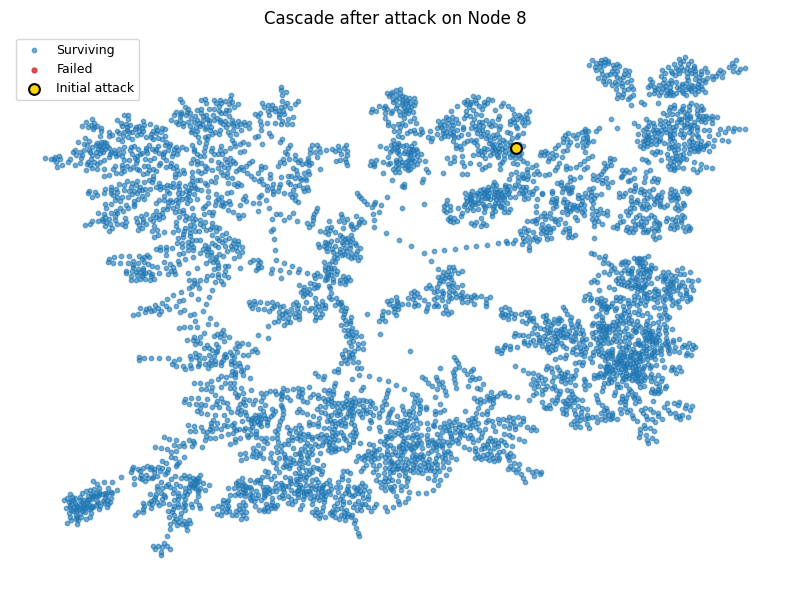

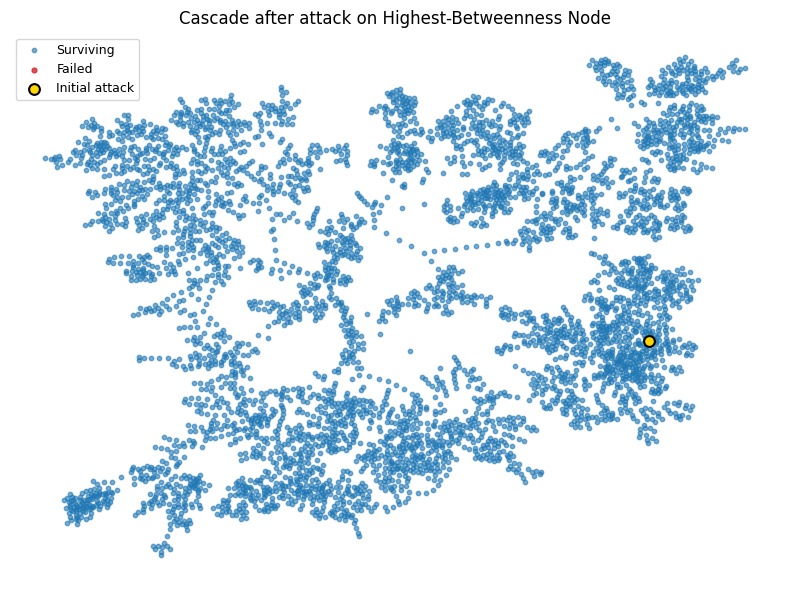

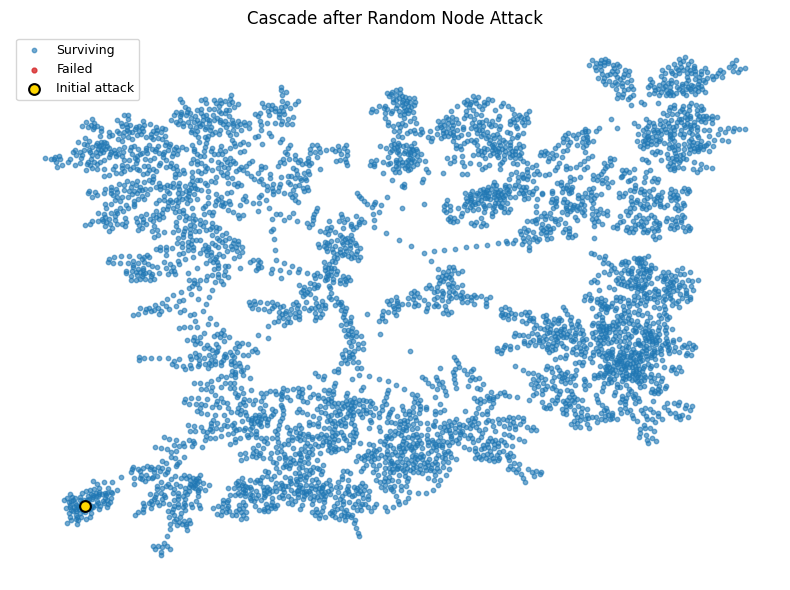

In [7]:
import matplotlib.pyplot as plt

def plot_cascade(G_original, result, title=None, attacked_node=None):
    G_final = result["final_graph"]
    failed = result["failed_nodes"]

    pos = nx.get_node_attributes(G_original, "pos")

    plt.figure(figsize=(8, 6))

    surviving = [n for n in G_final.nodes()]
    nx.draw_networkx_nodes(
        G_original,
        pos,
        nodelist=surviving,
        node_size=10,
        node_color="tab:blue",
        alpha=0.6,
        label="Surviving"
    )

    failed_existing = [n for n in failed if n in pos]
    nx.draw_networkx_nodes(
        G_original,
        pos,
        nodelist=failed_existing,
        node_size=12,
        node_color="tab:red",
        alpha=0.8,
        label="Failed"
    )

    if attacked_node is not None and attacked_node in pos:
        nx.draw_networkx_nodes(
            G_original,
            pos,
            nodelist=[attacked_node],
            node_size=60,
            node_color="gold",
            edgecolors="black",
            linewidths=1.5,
            label="Initial attack"
        )

    plt.title(title or "Cascading Failure Outcome")
    plt.axis("off")
    plt.legend(scatterpoints=1, fontsize=9)
    plt.tight_layout()
    plt.show()

# Node 8 attack
plot_cascade(
    G0,
    result_node8,
    title="Cascade after attack on Node 8",
    attacked_node=8
)

# Highest-betweenness attack
plot_cascade(
    G0,
    result_top,
    title="Cascade after attack on Highest-Betweenness Node",
    attacked_node=top_node
)

# Random node attack
plot_cascade(
    G0,
    result_rand,
    title="Cascade after Random Node Attack",
    attacked_node=rand_node
)

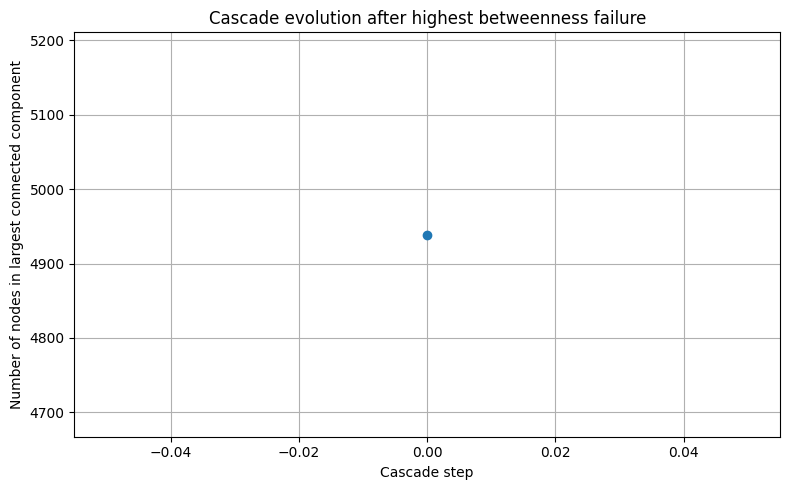

In [8]:
import matplotlib.pyplot as plt
lcc=result_top["lcc_history"]
steps=range(len(lcc))

plt.figure(figsize=(8,5))
plt.plot(steps, lcc, marker='o')
plt.xlabel("Cascade step")
plt.ylabel("Number of nodes in largest connected component")
plt.title("Cascade evolution after highest betweenness failure")
plt.grid(True)
plt.tight_layout()
plt.show()

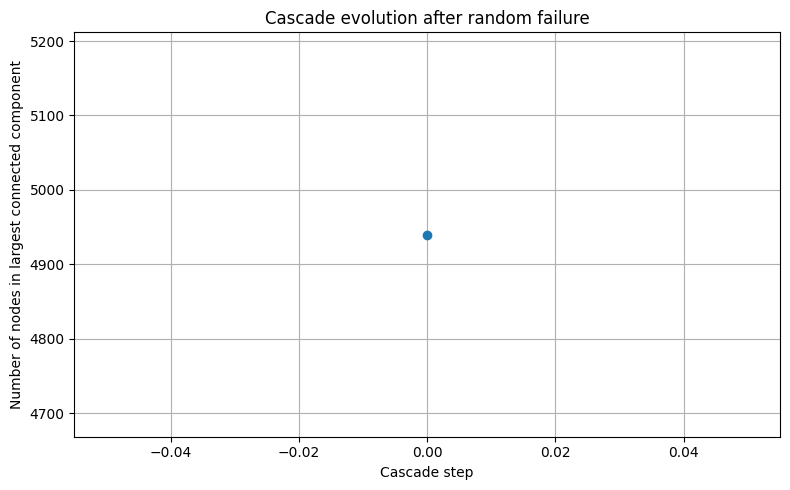

In [9]:
lcc_rand=result_rand["lcc_history"]
steps_rand=range(len(lcc_rand))

plt.figure(figsize=(8,5))
plt.plot(steps_rand, lcc_rand, marker='o')
plt.xlabel("Cascade step")
plt.ylabel("Number of nodes in largest connected component")
plt.title("Cascade evolution after random failure")
plt.grid(True)
plt.tight_layout()
plt.show()

Graph loaded: 4941 nodes, 6594 edges
   attack_size  total_failed  largest_cc  steps
0            1             1        4939      1
1            6            10        4897      4
2           11            18        4866      4
3           16            23        4847      4
4           21            28        4805      4


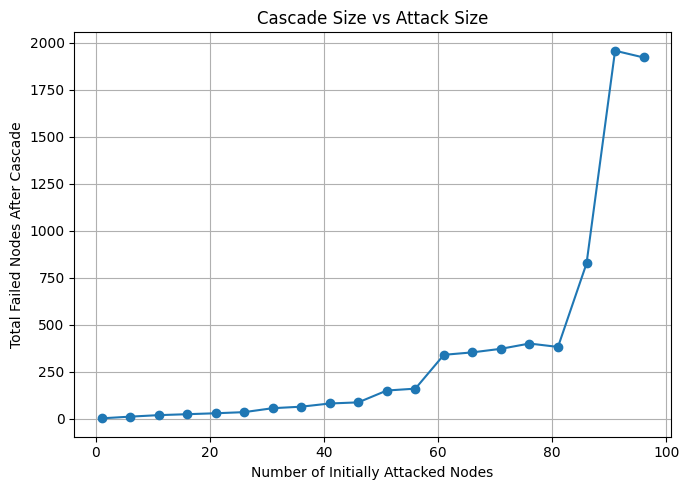

In [10]:
import pandas as pd

def load_data_with_attributes(edges_path="data/edges.csv", nodes_path="data/nodes_lc.csv"):
    edges = pd.read_csv(edges_path)
    nodes = pd.read_csv(nodes_path)

    G = nx.from_pandas_edgelist(
        edges,
        source="source",
        target="target",
        create_using=nx.Graph(),
    )

    for _, row in nodes.iterrows():
        n = row["index"]

        node_attrs = {}

        if {"pos_x", "pos_y"}.issubset(nodes.columns):
            node_attrs["pos"] = [row["pos_x"], row["pos_y"]]

        for col in nodes.columns:
            if col not in ["index", "pos_x", "pos_y"]:
                node_attrs[col] = row[col]

        G.add_node(n, **node_attrs)

    print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    return G

G = load_data_with_attributes()

def reset_node_states(G):
    for n in G.nodes():
        G.nodes[n]["failed"] = False

def high_degree_node_attack(G0, number_of_nodes=1):
    node_degrees = dict(G.degree())
    sorted_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)
    return [sorted_nodes[i][0] for i in range(number_of_nodes)]

def get_intack_neighbours(G, node):
    return [
        neighbor
        for neighbor in G.neighbors(node)
        if not G.nodes[neighbor]["failed"]
    ]

def calculate_outputs(G):
    intact_nodes = [n for n in G.nodes() if not G.nodes[n]["failed"]]
    failed_nodes = [n for n in G.nodes() if G.nodes[n]["failed"]]

    intact_subgraph = G.subgraph(intact_nodes)
    largest_cc = max(nx.connected_components(intact_subgraph), key=len, default=set())

    return {
        "num_failed_nodes": len(failed_nodes),
        "num_intact_nodes": len(intact_nodes),
        "size_largest_cc": len(largest_cc)
    }

def cascade_failure_proportional_load_distribution(G0, failed_nodes0):
    G = G0.copy()

    current_failed = list(failed_nodes0)
    failed_per_step = []
    steps = 0

    while current_failed:
        steps += 1
        new_failed = set()

        for n in current_failed:
            if G.nodes[n]["failed"]:
                continue

            G.nodes[n]["failed"] = True
            neighbors = get_intack_neighbours(G, n)
            load = G.nodes[n]["load"]

            if neighbors:
                total_capacity = sum(G.nodes[v]["capacity"] for v in neighbors)

                for neighbor in neighbors:
                    load_share = (G.nodes[neighbor]["capacity"] / total_capacity) * load
                    G.nodes[neighbor]["load"] += load_share
                    if G.nodes[neighbor]["load"] > G.nodes[neighbor]["capacity"]:
                        new_failed.add(neighbor)

            G.nodes[n]["load"] = 0

        failed_per_step.append(len(new_failed))
        current_failed = list(new_failed)

    outputs = calculate_outputs(G)
    return G, steps, failed_per_step, outputs

def run_attack_experiment(G0, attack_size):
    G = G0.copy()
    reset_node_states(G)

    attacked_nodes = high_degree_node_attack(G, attack_size)

    G_after, steps, failed_per_step, outputs = cascade_failure_proportional_load_distribution(
        G, attacked_nodes
    )

    return {
        "attack_size": attack_size,
        "total_failed": outputs["num_failed_nodes"],
        "largest_cc": outputs["size_largest_cc"],
        "steps": steps
    }


def draw_graph_after_failure(G, title):
    pos = nx.get_node_attributes(G, "pos")

    plt.figure(figsize=(10, 8))

    failed_edges = []
    intact_edges = []
    for u, v in G.edges():
        if G.nodes[u]["failed"] and G.nodes[v]["failed"]:
            failed_edges.append((u, v))
        else:
            intact_edges.append((u, v))

    nx.draw_networkx_edges(G, pos, edgelist=intact_edges, edge_color='grey', alpha=0.7)

    nx.draw_networkx_edges(G, pos, edgelist=failed_edges, edge_color='red', alpha=0.9)

    node_colors = ["#9c0101" if G.nodes[n]["failed"] else "#50bee6" for n in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3)

    plt.title(title)
    plt.axis('off')
    plt.show()

attacked_nodes = high_degree_node_attack(G, number_of_nodes=50)
G_after_failure, steps, failed_per_step, outputs = cascade_failure_proportional_load_distribution(G, attacked_nodes)

results = []

attack_sizes = range(1, 101, 5)  # adjust as needed

for k in attack_sizes:
    result = run_attack_experiment(G, k)
    results.append(result)

df_degree = pd.DataFrame(results)
print(df_degree.head())

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(df_degree["attack_size"], df_degree["total_failed"], marker="o")
plt.xlabel("Number of Initially Attacked Nodes")
plt.ylabel("Total Failed Nodes After Cascade")
plt.title("Cascade Size vs Attack Size")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def load_data_with_attributes(edges_path="data/edges.csv", nodes_path="data/nodes_lc.csv"):
    edges = pd.read_csv(edges_path)
    nodes = pd.read_csv(nodes_path)

    G = nx.from_pandas_edgelist(
        edges,
        source="source",
        target="target",
        create_using=nx.Graph(),
    )

    for _, row in nodes.iterrows():
        n = row["index"]

        node_attrs = {}

        if {"pos_x", "pos_y"}.issubset(nodes.columns):
            node_attrs["pos"] = [row["pos_x"], row["pos_y"]]

        for col in nodes.columns:
            if col not in ["index", "pos_x", "pos_y"]:
                node_attrs[col] = row[col]

        G.add_node(n, **node_attrs)

    print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    return G


G = load_data_with_attributes()

def reset_node_states(G):
    for n in G.nodes():
        G.nodes[n]["failed"] = False


betweenness = nx.betweenness_centrality(G, normalized=True)

sorted_nodes = [
    n for n, _ in sorted(
        betweenness.items(),
        key=lambda x: x[1],
        reverse=True
    )
]


def high_betweenness_node_attack(sorted_nodes, number_of_nodes):
    return sorted_nodes[:number_of_nodes]


def get_intack_neighbours(G, node):
    return [
        neighbor
        for neighbor in G.neighbors(node)
        if not G.nodes[neighbor]["failed"]
    ]


def calculate_outputs(G):
    intact_nodes = [n for n in G.nodes() if not G.nodes[n]["failed"]]
    failed_nodes = [n for n in G.nodes() if G.nodes[n]["failed"]]

    intact_subgraph = G.subgraph(intact_nodes)
    largest_cc = max(nx.connected_components(intact_subgraph), key=len, default=set())

    return {
        "num_failed_nodes": len(failed_nodes),
        "num_intact_nodes": len(intact_nodes),
        "size_largest_cc": len(largest_cc)
    }


def cascade_failure_proportional_load_distribution(G0, failed_nodes0):
    G = G0.copy()

    current_failed = list(failed_nodes0)
    failed_per_step = []
    steps = 0

    while current_failed:
        steps += 1
        new_failed = set()

        for n in current_failed:
            if G.nodes[n]["failed"]:
                continue

            G.nodes[n]["failed"] = True
            neighbors = get_intack_neighbours(G, n)
            load = G.nodes[n]["load"]

            if neighbors:
                total_capacity = sum(G.nodes[v]["capacity"] for v in neighbors)

                for neighbor in neighbors:
                    load_share = (G.nodes[neighbor]["capacity"] / total_capacity) * load
                    G.nodes[neighbor]["load"] += load_share
                    if G.nodes[neighbor]["load"] > G.nodes[neighbor]["capacity"]:
                        new_failed.add(neighbor)

            G.nodes[n]["load"] = 0

        failed_per_step.append(len(new_failed))
        current_failed = list(new_failed)

    outputs = calculate_outputs(G)
    return G, steps, failed_per_step, outputs


def run_betweenness_attack_experiment(G0, attack_size, sorted_nodes):
    G = G0.copy()
    reset_node_states(G)

    attacked_nodes = high_betweenness_node_attack(
        sorted_nodes, attack_size
    )

    G_after, steps, failed_per_step, outputs = cascade_failure_proportional_load_distribution(
        G, attacked_nodes
    )

    return {
        "attack_size": attack_size,
        "total_failed": outputs["num_failed_nodes"],
        "largest_cc": outputs["size_largest_cc"],
        "steps": steps
    }


results_bc = []

attack_sizes = range(1, 101, 5)

for k in attack_sizes:
    result = run_betweenness_attack_experiment(G, k, sorted_nodes)
    results_bc.append(result)

df_bc = pd.DataFrame(results_bc)
print(df_bc)


plt.figure(figsize=(7, 5))
plt.plot(
    df_bc["attack_size"],
    df_bc["total_failed"],
    marker="o",
    label="Betweenness-based attack"
)

plt.xlabel("Number of Initially Attacked Nodes")
plt.ylabel("Total Failed Nodes After Cascade")
plt.title("Cascade Size vs Betweenness-Based Attack Size")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Graph loaded: 4941 nodes, 6594 edges


KeyboardInterrupt: 

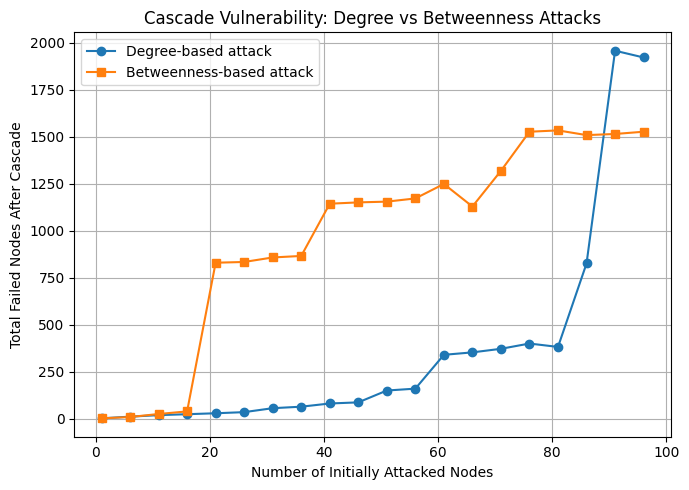

In [ ]:
plt.figure(figsize=(7, 5))

plt.plot(
    df_degree["attack_size"],
    df_degree["total_failed"],
    marker="o",
    label="Degree-based attack"
)

plt.plot(
    df_bc["attack_size"],
    df_bc["total_failed"],
    marker="s",
    label="Betweenness-based attack"
)

plt.xlabel("Number of Initially Attacked Nodes")
plt.ylabel("Total Failed Nodes After Cascade")
plt.title("Cascade Vulnerability: Degree vs Betweenness Attacks")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

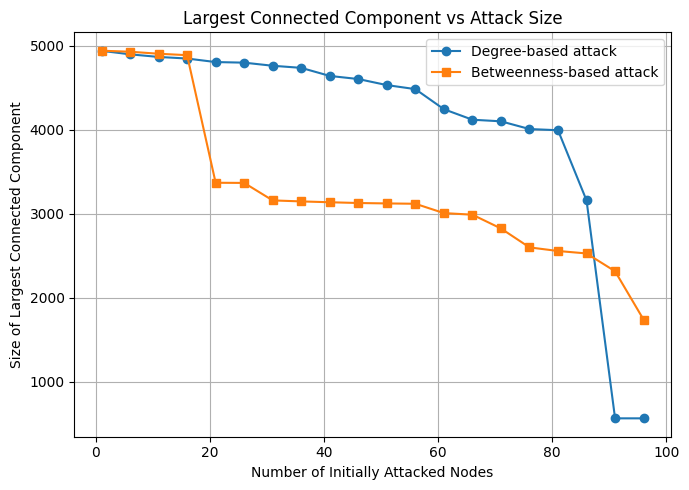

In [ ]:
plt.figure(figsize=(7, 5))

plt.plot(
    df_degree["attack_size"],
    df_degree["largest_cc"],
    marker="o",
    label="Degree-based attack"
)

plt.plot(
    df_bc["attack_size"],
    df_bc["largest_cc"],
    marker="s",
    label="Betweenness-based attack"
)

plt.xlabel("Number of Initially Attacked Nodes")
plt.ylabel("Size of Largest Connected Component")
plt.title("Largest Connected Component vs Attack Size")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
from importlib import reload
from matplotlib import pyplot as plt
import numpy as np
import src.data
import cascade_failure.simple_cascade
import src.visualization
import src.atack
reload(cascade_failure.simple_cascade)
reload(src.data)
reload(src.visualization)
reload(src.atack)

from src.data import load_data_with_attributes
from src.visualization import draw_graph_after_failure, draw_graph_with_node_highlighted, draw_graph_after_failure_with_attacked_nodes
from cascade_failure.simple_cascade import cascade_failure_equal_load_distribution, cascade_failure_proportional_load_distribution
from src.atack import random_node_attack, high_degree_node_attack, high_load_capacity_ratio_node_attack, high_load_capacity_ratio_and_degree_node_attack, high_load_node_attack,high_betweenness_node_attack

In [63]:
G = load_data_with_attributes()

In [66]:
def hihi_lcr(G0, num_nodes_to_attack):
    num_failed_nodes = [0, 0, 0, 0]

    # Proportional Load Distribution
    G = G0.copy()
    attacked_nodes = high_betweenness_node_attack(G, number_of_nodes=num_nodes_to_attack)
    G, steps, failed_per_step, outputs = cascade_failure_proportional_load_distribution(G, attacked_nodes)
    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Proportional Load Distribution")
    print(f"Number of cascade steps: {steps}")
    print(f"Failed nodes per step: {failed_per_step}")
    print(f"Final outputs: {outputs}")
    print("Attacked nodes:", attacked_nodes)
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    num_failed_nodes[0] = num_failed

    # Equal Load Distribution
    G = G0.copy()
    attacked_nodes = high_betweenness_node_attack(G, number_of_nodes=num_nodes_to_attack)
    G, steps, failed_per_step, outputs = cascade_failure_equal_load_distribution(G, attacked_nodes)
    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Equal Load Distribution")
    print(f"Number of cascade steps: {steps}")
    print(f"Failed nodes per step: {failed_per_step}")
    print(f"Final outputs: {outputs}")
    print("Attacked nodes:", attacked_nodes)
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    num_failed_nodes[1] = num_failed

    #Proportional Load Distribution sequential 50 node attacks
    G = G0.copy()
    attacked_nodes = []
    for i in range(num_nodes_to_attack):
        attacked_node = high_betweenness_node_attack(G, number_of_nodes=1, k=50)
        attacked_nodes.extend(attacked_node)
        G, _, _, _ = cascade_failure_proportional_load_distribution(G, attacked_node)

    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Proportional Load Distribution")
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    print(f"Total failed nodes after sequential attacks: {num_failed}")
    print("Attacked nodes:", attacked_nodes)
    num_failed_nodes[2] = num_failed

    G = load_data_with_attributes()

    # Equal Load Distribution sequential 50 node attacks
    G = G0.copy()
    attacked_nodes = []
    for i in range(num_nodes_to_attack):
        attacked_node = high_betweenness_node_attack(G, number_of_nodes=1, k=50)
        attacked_nodes.extend(attacked_node)
        G, _, _, _ = cascade_failure_equal_load_distribution(G, attacked_node)

    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Equal Load Distribution")
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    print(f"Total failed nodes after sequential attacks: {num_failed}")
    print("Attacked nodes:", attacked_nodes)
    num_failed_nodes[3] = num_failed

    return num_failed_nodes


def hihi_l(G0, num_nodes_to_attack):
    num_failed_nodes = [0, 0, 0, 0]

    # Proportional Load Distribution
    G = G0.copy()
    attacked_nodes = high_load_node_attack(G, number_of_nodes=num_nodes_to_attack)
    G, steps, failed_per_step, outputs = cascade_failure_proportional_load_distribution(G, attacked_nodes)
    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Proportional Load Distribution")
    print(f"Number of cascade steps: {steps}")
    print(f"Failed nodes per step: {failed_per_step}")
    print(f"Final outputs: {outputs}")
    print("Attacked nodes:", attacked_nodes)
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    num_failed_nodes[0] = num_failed

    # Equal Load Distribution
    G = G0.copy()
    attacked_nodes = high_load_node_attack(G, number_of_nodes=num_nodes_to_attack)
    G, steps, failed_per_step, outputs = cascade_failure_equal_load_distribution(G, attacked_nodes)
    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Equal Load Distribution")
    print(f"Number of cascade steps: {steps}")
    print(f"Failed nodes per step: {failed_per_step}")
    print(f"Final outputs: {outputs}")
    print("Attacked nodes:", attacked_nodes)
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    num_failed_nodes[1] = num_failed

    # Proportional Load Distribution sequential 50 node attacks
    G = G0.copy()
    attacked_nodes = []
    for i in range(num_nodes_to_attack):
        attacked_node = high_load_node_attack(G, number_of_nodes=1)
        attacked_nodes.extend(attacked_node)
        G, _, _, _ = cascade_failure_proportional_load_distribution(G, attacked_node)

    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Proportional Load Distribution")
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    print(f"Total failed nodes after sequential attacks: {num_failed}")
    print("Attacked nodes:", attacked_nodes)
    num_failed_nodes[2] = num_failed

    G = load_data_with_attributes()

    # Equal Load Distribution sequential 50 node attacks
    G = G0.copy()
    attacked_nodes = []
    for i in range(num_nodes_to_attack):
        attacked_node = high_load_node_attack(G, number_of_nodes=1)
        attacked_nodes.extend(attacked_node)
        G, _, _, _ = cascade_failure_equal_load_distribution(G, attacked_node)

    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Equal Load Distribution")
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    print(f"Total failed nodes after sequential attacks: {num_failed}")
    print("Attacked nodes:", attacked_nodes)
    num_failed_nodes[3] = num_failed

    return num_failed_nodes

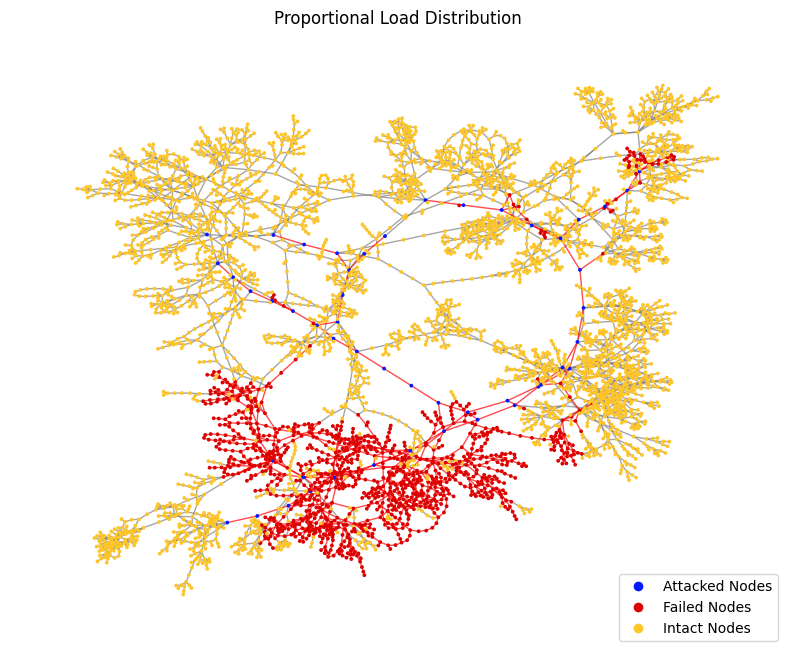

Number of cascade steps: 107
Failed nodes per step: [23, 11, 12, 9, 11, 12, 7, 5, 7, 5, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 3, 4, 3, 2, 9, 9, 7, 4, 2, 1, 2, 7, 7, 8, 7, 9, 11, 11, 13, 15, 16, 21, 29, 32, 28, 36, 36, 32, 26, 24, 23, 29, 21, 25, 35, 28, 26, 25, 23, 14, 19, 19, 17, 24, 33, 29, 22, 18, 17, 11, 7, 4, 3, 2, 2, 3, 6, 7, 7, 9, 10, 10, 11, 6, 11, 6, 9, 10, 8, 4, 2, 1, 1, 4, 5, 4, 7, 10, 8, 3, 1, 0]
Final outputs: {'num_failed_nodes': 1153, 'num_intact_nodes': 3788, 'size_largest_cc': 3123}
Attacked nodes: [4164, 2543, 1243, 4219, 2528, 1267, 1308, 1244, 426, 2606, 2594, 2605, 69, 108, 1167, 4120, 2235, 70, 2223, 393, 1476, 1125, 427, 1131, 2557, 4207, 2312, 4206, 4199, 1166, 4837, 396, 4832, 2231, 2612, 420, 1148, 2370, 2317, 1340, 4652, 2249, 1178, 2532, 1091, 4476, 285, 2298, 3785, 2343]


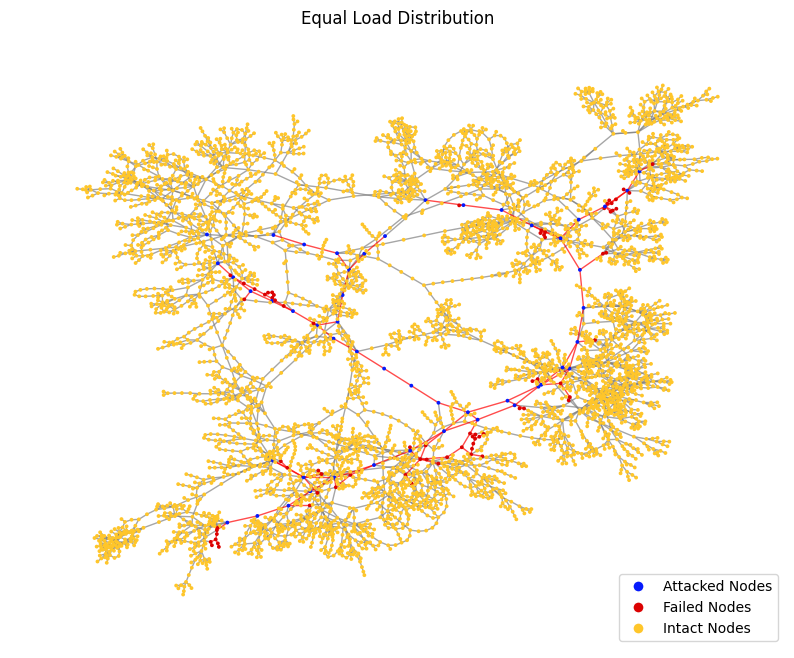

Number of cascade steps: 12
Failed nodes per step: [32, 18, 8, 5, 5, 4, 3, 1, 1, 3, 1, 0]
Final outputs: {'num_failed_nodes': 124, 'num_intact_nodes': 4817, 'size_largest_cc': 4802}
Attacked nodes: [4164, 2543, 1243, 4219, 2528, 1267, 1308, 1244, 426, 2606, 2594, 2605, 69, 108, 1167, 4120, 2235, 70, 2223, 393, 1476, 1125, 427, 1131, 2557, 4207, 2312, 4206, 4199, 1166, 4837, 396, 4832, 2231, 2612, 420, 1148, 2370, 2317, 1340, 4652, 2249, 1178, 2532, 1091, 4476, 285, 2298, 3785, 2343]


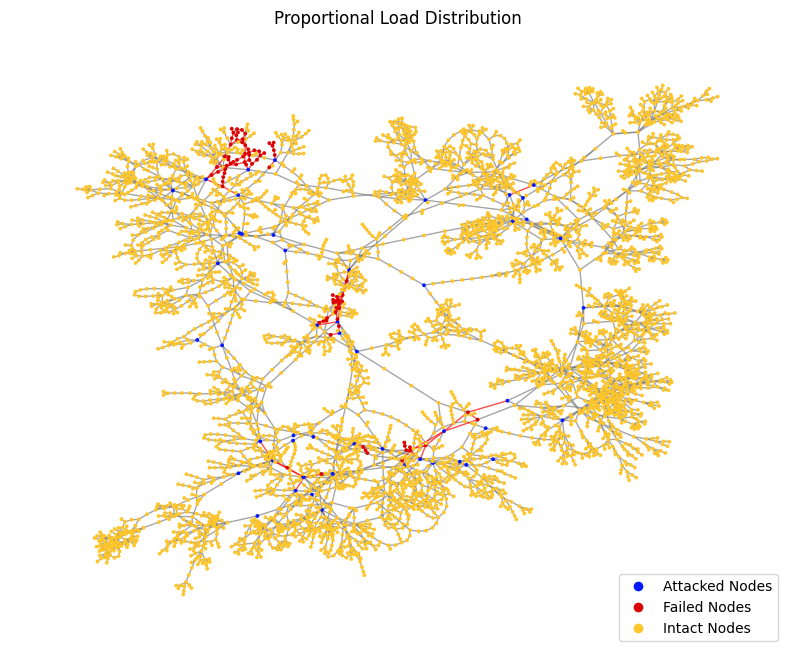

Total failed nodes after sequential attacks: 133
Attacked nodes: [1243, 4164, 426, 2235, 2543, 69, 1091, 393, 4652, 3975, 1253, 386, 1353, 396, 2414, 4588, 2594, 1163, 2458, 1313, 1072, 1523, 1219, 4832, 129, 4458, 2562, 522, 207, 1106, 3312, 1178, 4867, 1166, 4876, 1506, 3329, 4897, 1326, 4537, 3331, 1119, 3337, 1147, 1224, 1102, 1195, 1170, 1205, 1343]


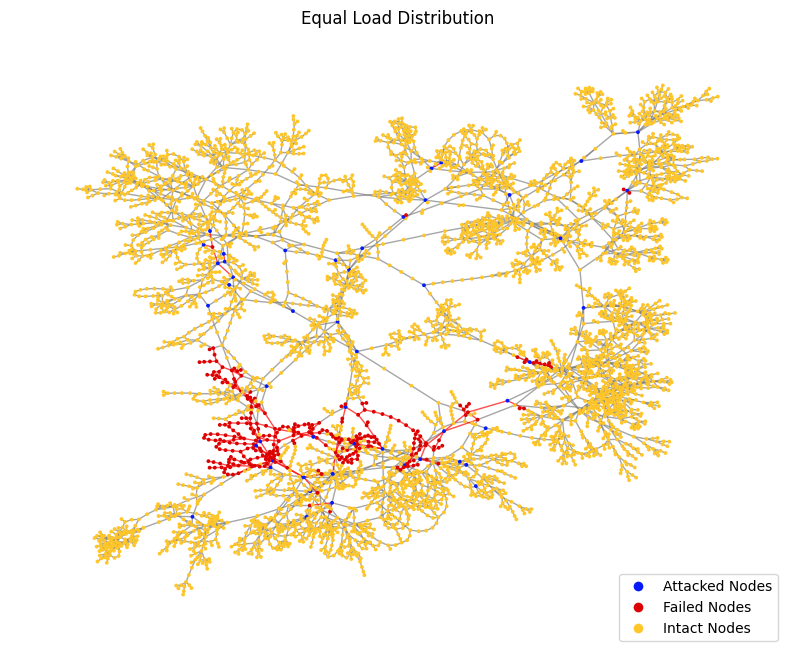

Total failed nodes after sequential attacks: 338
Attacked nodes: [2543, 426, 2235, 1091, 69, 393, 2717, 1253, 1353, 402, 2364, 4652, 2231, 2233, 2249, 4897, 2368, 4508, 4473, 4507, 4608, 4643, 1243, 2594, 1163, 1313, 1072, 1523, 1685, 184, 4859, 207, 4164, 80, 3975, 744, 1166, 1506, 1326, 726, 1106, 1148, 1403, 1309, 1400, 4199, 1224, 337, 1090, 3770]


In [67]:
fn_1 = hihi_lcr(G, 50)
#fn_2 = hihi_l(G, 50)

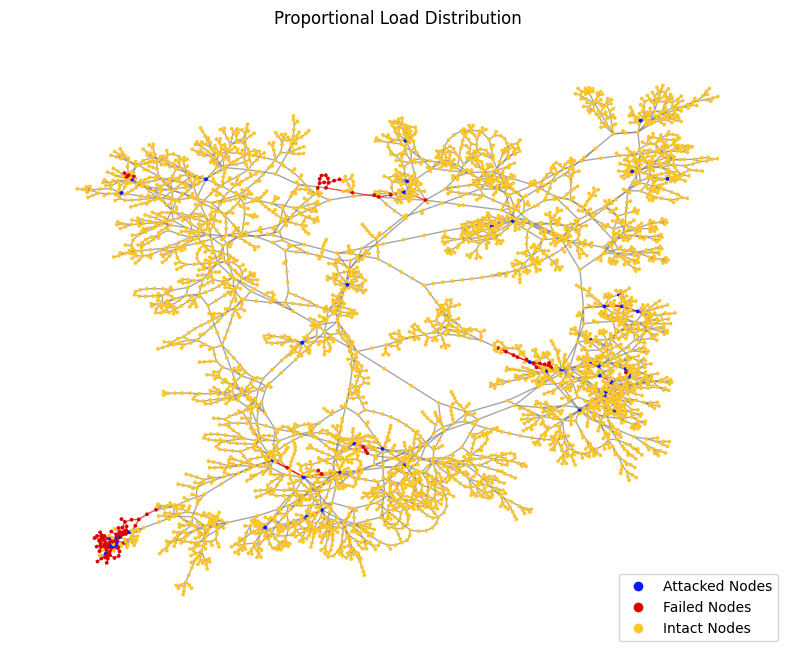

Number of cascade steps: 12
Failed nodes per step: [16, 10, 8, 7, 11, 11, 12, 14, 12, 3, 1, 0]
Final outputs: {'num_failed_nodes': 148, 'num_intact_nodes': 4793, 'size_largest_cc': 4532}
Attacked nodes: [2553, 4458, 831, 3468, 4345, 2382, 2542, 2575, 2585, 3895, 1224, 2434, 2439, 2617, 2662, 1005, 1309, 1334, 2282, 490, 4332, 4352, 4373, 4381, 4384, 4395, 725, 1030, 1050, 1091, 1106, 1166, 1170, 1326, 1460, 2533, 2554, 2586, 2608, 2717, 2800, 2851, 2936, 3128, 3312, 3355, 3838, 4346, 4359, 4361]


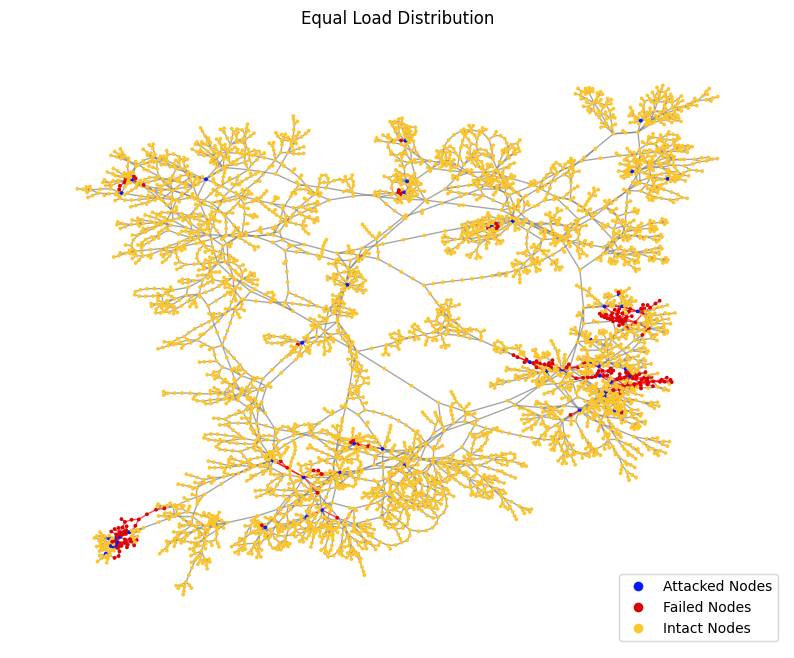

Number of cascade steps: 19
Failed nodes per step: [55, 23, 17, 16, 16, 6, 6, 6, 8, 10, 10, 7, 3, 2, 3, 4, 3, 1, 0]
Final outputs: {'num_failed_nodes': 234, 'num_intact_nodes': 4707, 'size_largest_cc': 4386}
Attacked nodes: [2553, 4458, 831, 3468, 4345, 2382, 2542, 2575, 2585, 3895, 1224, 2434, 2439, 2617, 2662, 1005, 1309, 1334, 2282, 490, 4332, 4352, 4373, 4381, 4384, 4395, 725, 1030, 1050, 1091, 1106, 1166, 1170, 1326, 1460, 2533, 2554, 2586, 2608, 2717, 2800, 2851, 2936, 3128, 3312, 3355, 3838, 4346, 4359, 4361]


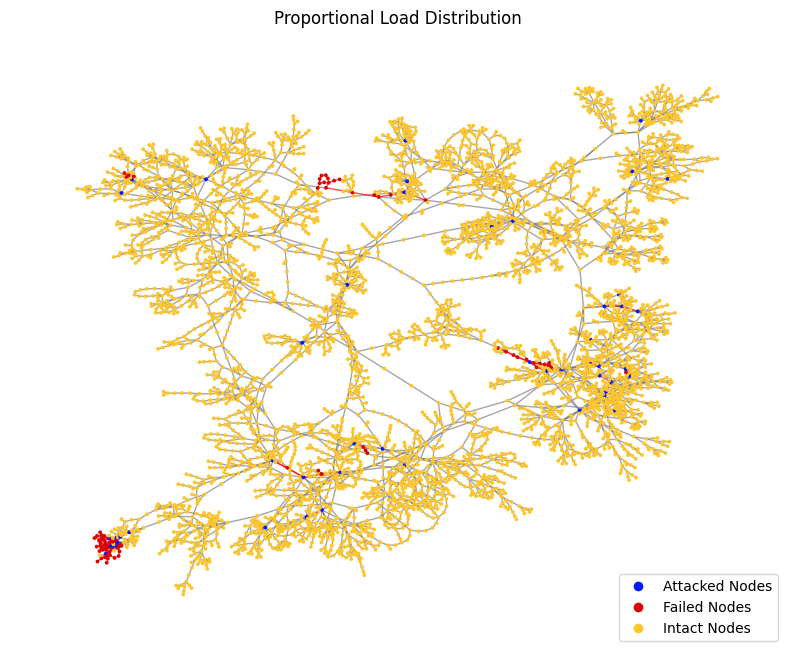

Total failed nodes after sequential attacks: 130
Attacked nodes: [2553, 4458, 831, 3468, 4345, 2382, 2542, 2575, 2585, 3895, 1224, 2434, 2439, 2617, 2662, 1005, 1309, 1334, 2282, 490, 4332, 4352, 4373, 4381, 4384, 4395, 725, 1030, 1050, 1091, 1106, 1166, 1170, 1326, 1460, 2533, 2554, 2586, 2608, 2717, 2800, 2851, 2936, 3128, 3312, 3355, 3838, 4346, 4359, 4361]


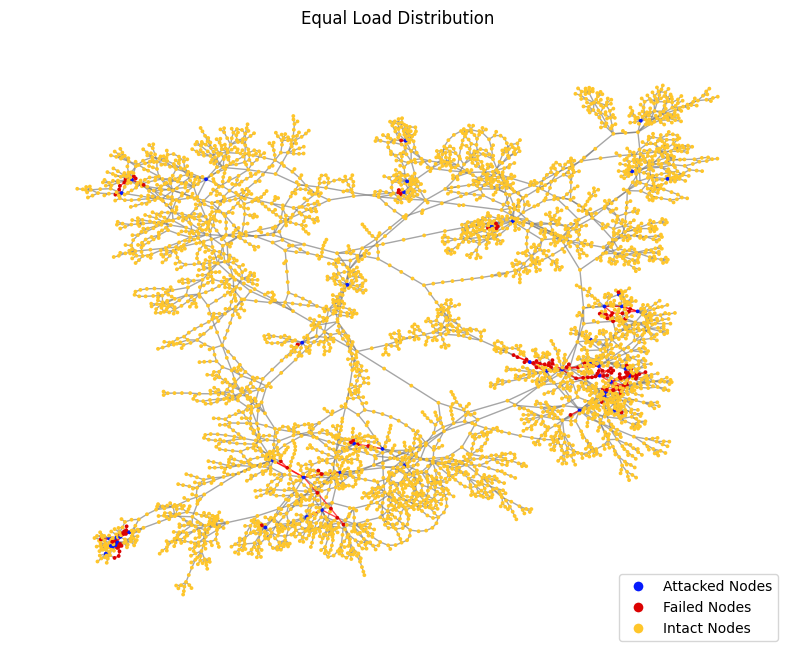

Total failed nodes after sequential attacks: 165
Attacked nodes: [2553, 4458, 831, 3468, 4345, 2382, 2542, 2575, 2585, 3895, 1224, 2434, 2439, 2617, 2662, 1005, 1309, 1334, 2282, 490, 4332, 4352, 4373, 4381, 4384, 4395, 725, 1030, 1050, 1091, 1106, 1166, 1170, 1326, 1460, 2533, 2554, 2586, 2608, 2717, 2800, 2851, 2936, 3128, 3312, 3355, 3838, 4346, 4359, 4361]


In [68]:
def hihi_deg(G0, num_nodes_to_attack):
    num_failed_nodes = [0, 0, 0, 0]

    # Proportional Load Distribution
    G = G0.copy()
    attacked_nodes = high_degree_node_attack(G, number_of_nodes=num_nodes_to_attack)
    G, steps, failed_per_step, outputs = cascade_failure_proportional_load_distribution(G, attacked_nodes)
    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Proportional Load Distribution")
    print(f"Number of cascade steps: {steps}")
    print(f"Failed nodes per step: {failed_per_step}")
    print(f"Final outputs: {outputs}")
    print("Attacked nodes:", attacked_nodes)
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    num_failed_nodes[0] = num_failed

    # Equal Load Distribution
    G = G0.copy()
    attacked_nodes = high_degree_node_attack(G, number_of_nodes=num_nodes_to_attack)
    G, steps, failed_per_step, outputs = cascade_failure_equal_load_distribution(G, attacked_nodes)
    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Equal Load Distribution")
    print(f"Number of cascade steps: {steps}")
    print(f"Failed nodes per step: {failed_per_step}")
    print(f"Final outputs: {outputs}")
    print("Attacked nodes:", attacked_nodes)
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    num_failed_nodes[1] = num_failed

    #Proportional Load Distribution sequential 50 node attacks
    G = G0.copy()
    attacked_nodes = []
    for i in range(num_nodes_to_attack):
        attacked_node = high_degree_node_attack(G, number_of_nodes=1)
        attacked_nodes.extend(attacked_node)
        G, _, _, _ = cascade_failure_proportional_load_distribution(G, attacked_node)

    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Proportional Load Distribution")
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    print(f"Total failed nodes after sequential attacks: {num_failed}")
    print("Attacked nodes:", attacked_nodes)
    num_failed_nodes[2] = num_failed

    G = load_data_with_attributes()

    # Equal Load Distribution sequential 50 node attacks
    G = G0.copy()
    attacked_nodes = []
    for i in range(num_nodes_to_attack):
        attacked_node = high_degree_node_attack(G, number_of_nodes=1)
        attacked_nodes.extend(attacked_node)
        G, _, _, _ = cascade_failure_equal_load_distribution(G, attacked_node)

    draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Equal Load Distribution")
    num_failed = sum(1 for n in G.nodes() if G.nodes[n]["failed"])
    print(f"Total failed nodes after sequential attacks: {num_failed}")
    print("Attacked nodes:", attacked_nodes)
    num_failed_nodes[3] = num_failed

    return num_failed_nodes

call=hihi_deg(G0, 50)

Starting Proportional Sequential Attack...


C:\Users\anna-\AppData\Local\Temp\ipykernel_47364\3031782687.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


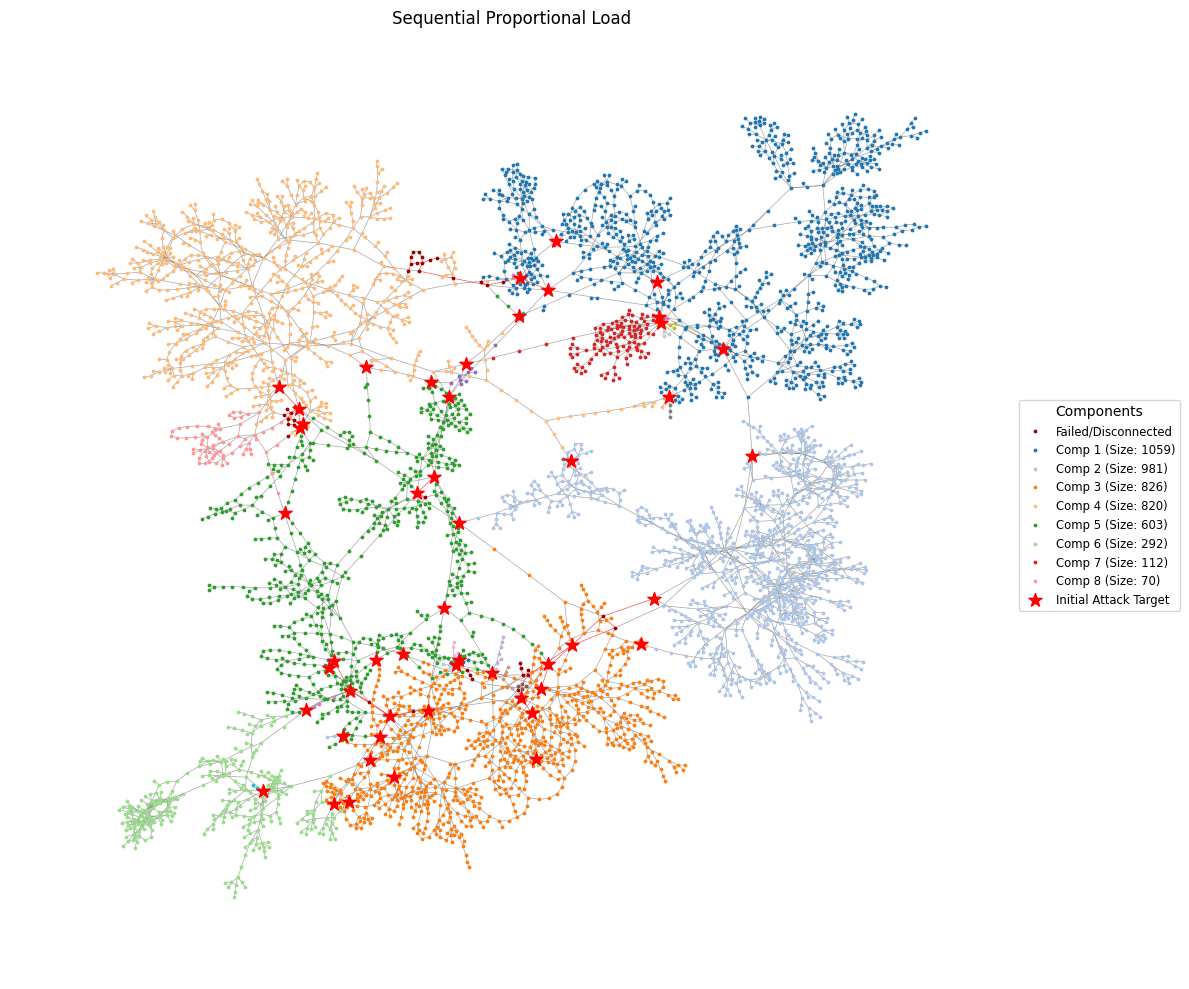

Starting Equal Sequential Attack...


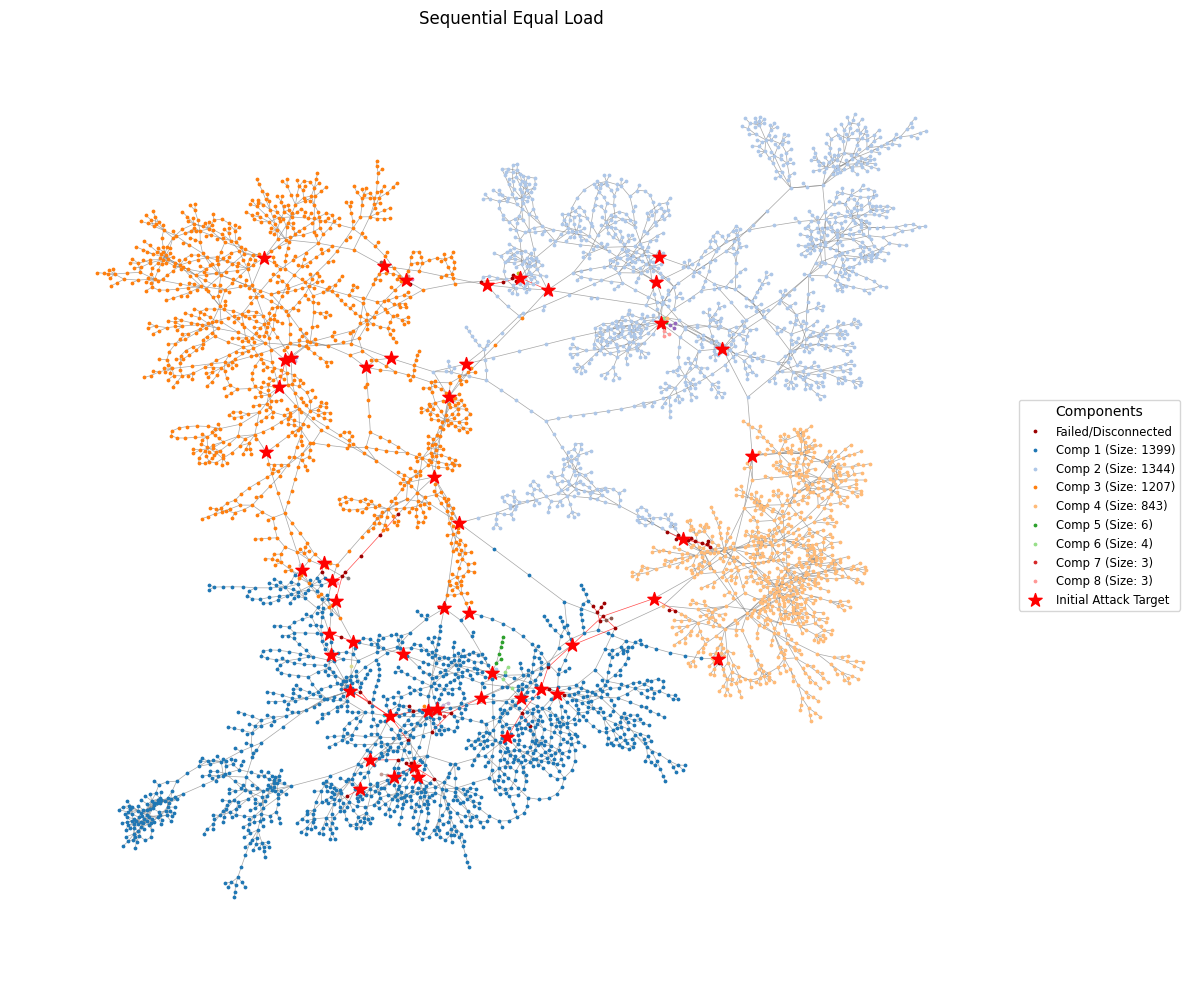

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

G0 = load_data_with_attributes()
layout_pos = {n: (d['pos'][0], d['pos'][1]) for n, d in G0.nodes(data=True) if 'pos' in d}

def draw_components_after_failure(G, title, pos, attacked_nodes):
    plt.figure(figsize=(12, 10)) 

    # 1. Separate Edges (Using your specific logic)
    failed_edges = []
    intact_edges = []
    for u, v in G.edges():
        if G.nodes[u].get("failed") and G.nodes[v].get("failed"):
            failed_edges.append((u, v))
        else:
            intact_edges.append((u, v))

    # Draw Edges
    nx.draw_networkx_edges(G, pos, edgelist=intact_edges, edge_color='grey', alpha=0.7, width=0.5)
    nx.draw_networkx_edges(G, pos, edgelist=failed_edges, edge_color='red', alpha=0.7, width=0.5)

    # 2. Identify Components and Failed Nodes
    active_nodes = [n for n in G.nodes() if not G.nodes[n].get("failed")]
    failed_nodes = [n for n in G.nodes() if G.nodes[n].get("failed")]
    
    G_active = G.subgraph(active_nodes)
    components = sorted(nx.connected_components(G_active), key=len, reverse=True)
    
    try:
        cmap = plt.cm.get_cmap('tab20')
    except:
        cmap = plt.colormaps.get_cmap('tab20')

    # 3. Draw Nodes and Build Legend
    # Draw Failed Nodes first
    nx.draw_networkx_nodes(G, pos, nodelist=failed_nodes, 
                           node_color="#9c0101", node_size=3, label="Failed/Disconnected")

    # Draw Active Components one by one
    for i, component in enumerate(components):
        comp_color = cmap(i % 20)
        label = f"Comp {i+1} (Size: {len(component)})" if i < 8 else ""
        
        nx.draw_networkx_nodes(G, pos, nodelist=list(component), 
                               node_color=[comp_color], 
                               node_size=3, 
                               label=label)

    # 4. OVERLAY ATTACKED NODES WITH STARS
    # We draw these last so they appear on top. node_shape='*' creates the star.
    if attacked_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=attacked_nodes, 
                               node_color="red", 
                               node_size=100, 
                               node_shape="*", 
                               label="Initial Attack Target")

    # Maintain your Title and Axis style
    plt.title(title)
    
    # Place legend
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1, fontsize='small', title="Components")
    
    plt.axis('off')
    plt.tight_layout() 
    plt.show()

# --- ATTACK LOGIC ---
def hihi_lcr(G_start, num_nodes_to_attack, pos):
    num_failed_nodes = [0, 0, 0, 0]
    
    # --- 1. Proportional Load Distribution Sequential ---
    print("Starting Proportional Sequential Attack...")
    G_prop = G_start.copy()
    attacked_nodes_prop = []
    for i in range(num_nodes_to_attack):
        # Get the target node
        attacked_node = high_betweenness_node_attack(G_prop, number_of_nodes=1, k=50)
        # Store it for the visualization star markers
        attacked_nodes_prop.extend(attacked_node)
        # Run the cascade
        G_prop, _, _, _ = cascade_failure_proportional_load_distribution(G_prop, attacked_node)

    # Call the visualization with the stars (pass attacked_nodes_prop as the 4th arg)
    draw_components_after_failure(G_prop, "Sequential Proportional Load", pos, attacked_nodes_prop)
    
    num_failed_nodes[2] = sum(1 for n in G_prop.nodes() if G_prop.nodes[n].get("failed"))

    # --- 2. Equal Load Distribution Sequential ---
    print("Starting Equal Sequential Attack...")
    G_equal = G_start.copy()
    attacked_nodes_equal = []
    for i in range(num_nodes_to_attack):
        attacked_node = high_betweenness_node_attack(G_equal, number_of_nodes=1, k=50)
        attacked_nodes_equal.extend(attacked_node)
        G_equal, _, _, _ = cascade_failure_equal_load_distribution(G_equal, attacked_node)

    # Call the visualization with the stars
    draw_components_after_failure(G_equal, "Sequential Equal Load", pos, attacked_nodes_equal)
    
    num_failed_nodes[3] = sum(1 for n in G_equal.nodes() if G_equal.nodes[n].get("failed"))

    return num_failed_nodes

# --- EXECUTION ---
fn_1 = hihi_lcr(G0, 50, layout_pos)


Starting Proportional Sequential Attack...


C:\Users\anna-\AppData\Local\Temp\ipykernel_47364\3489496970.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


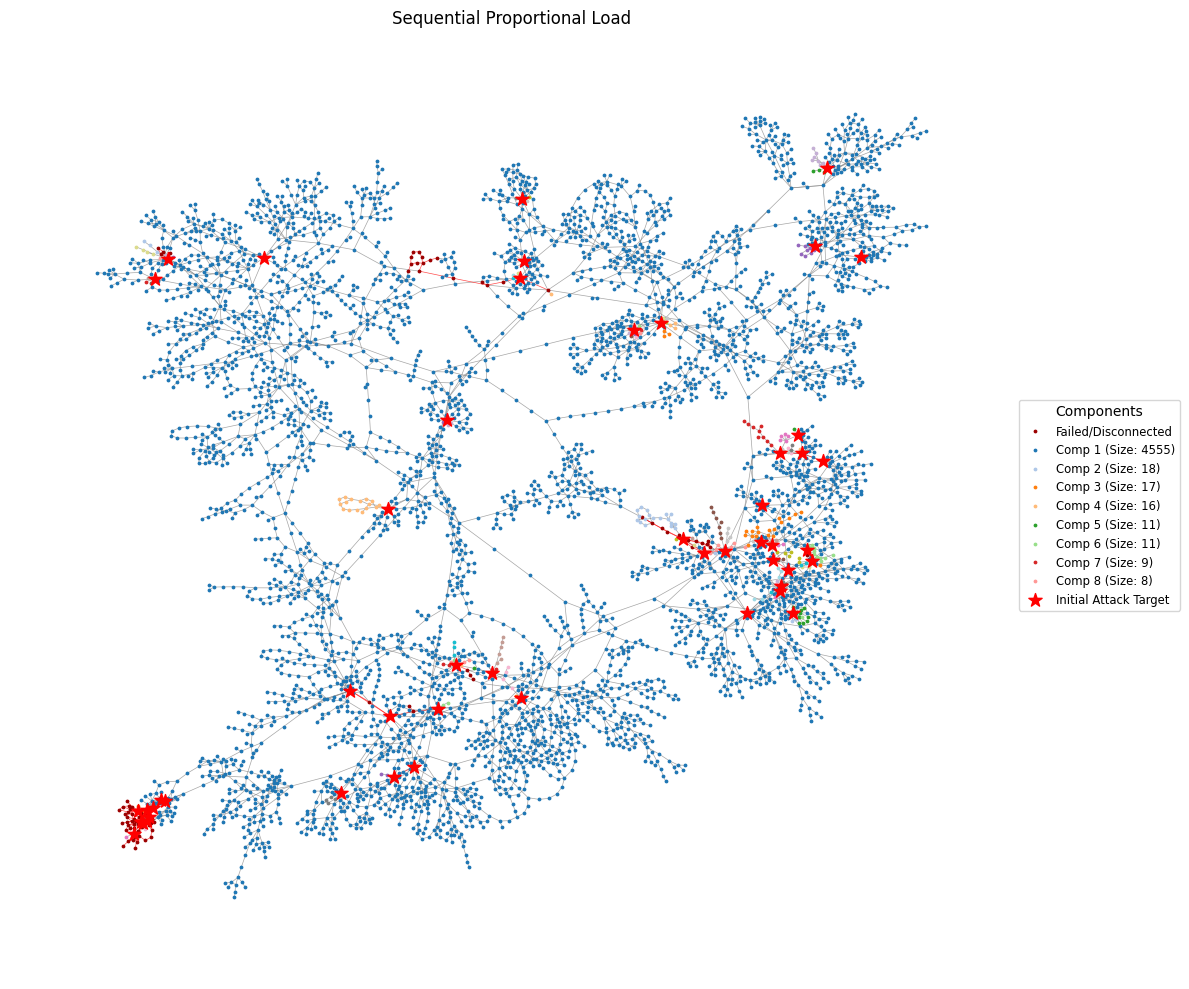

Starting Equal Sequential Attack...


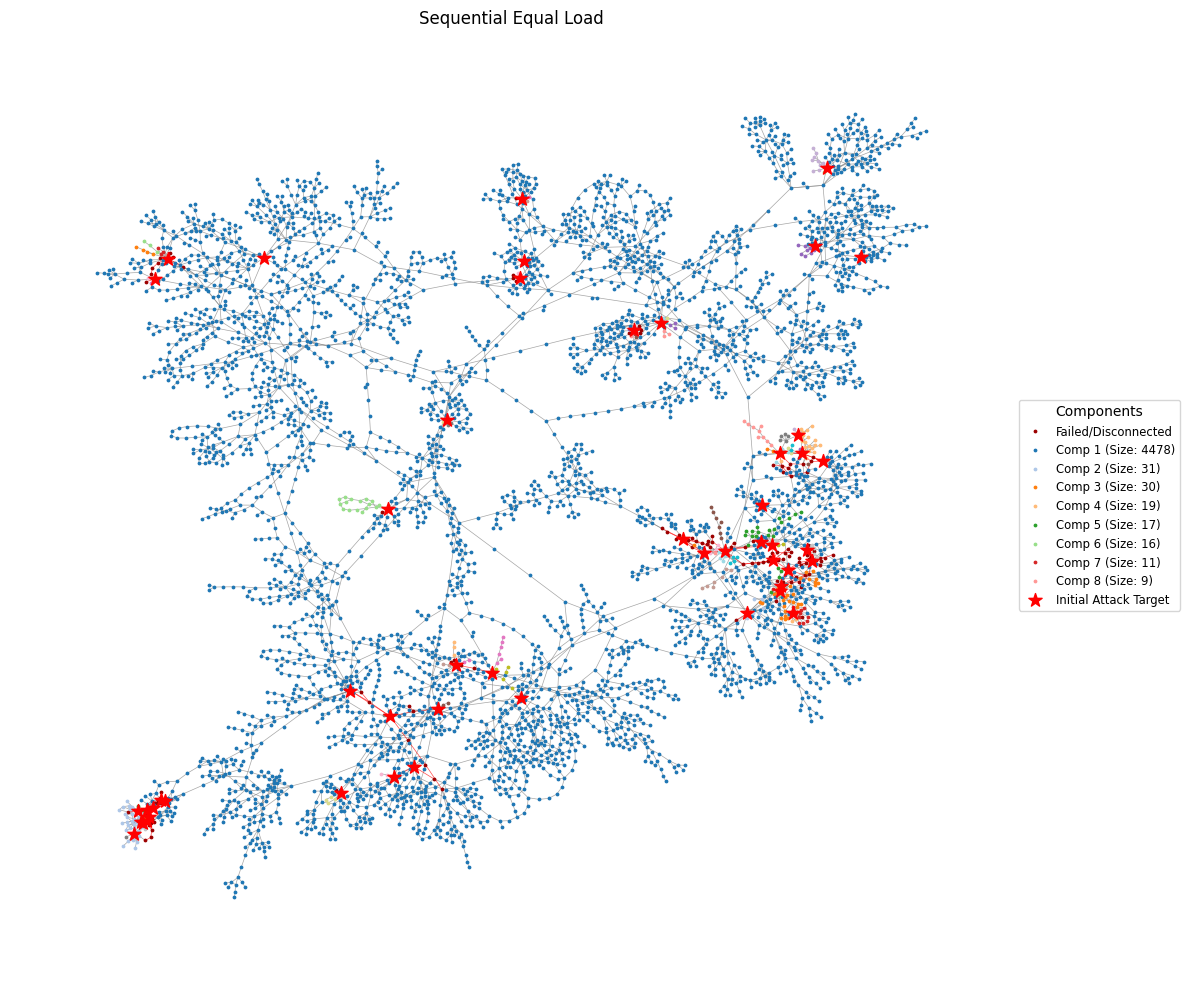

In [61]:
G0 = load_data_with_attributes()

# Extract coordinates from the "pos" list attribute
layout_pos = {n: (d['pos'][0], d['pos'][1]) for n, d in G0.nodes(data=True) if 'pos' in d}

# --- VISUALIZATION FUNCTION ---
def draw_graph_after_failure_with_components(G, title, pos, attacked_nodes):
    plt.figure(figsize=(12, 10)) 

    # 1. Separate Edges (Using your specific logic)
    failed_edges = []
    intact_edges = []
    for u, v in G.edges():
        if G.nodes[u].get("failed") and G.nodes[v].get("failed"):
            failed_edges.append((u, v))
        else:
            intact_edges.append((u, v))

    # Draw Edges
    nx.draw_networkx_edges(G, pos, edgelist=intact_edges, edge_color='grey', alpha=0.7, width=0.5)
    nx.draw_networkx_edges(G, pos, edgelist=failed_edges, edge_color='red', alpha=0.7, width=0.5)

    # 2. Identify Components and Failed Nodes
    active_nodes = [n for n in G.nodes() if not G.nodes[n].get("failed")]
    failed_nodes = [n for n in G.nodes() if G.nodes[n].get("failed")]
    
    G_active = G.subgraph(active_nodes)
    components = sorted(nx.connected_components(G_active), key=len, reverse=True)
    
    try:
        cmap = plt.cm.get_cmap('tab20')
    except:
        cmap = plt.colormaps.get_cmap('tab20')

    # 3. Draw Nodes and Build Legend
    # Draw Failed Nodes first
    nx.draw_networkx_nodes(G, pos, nodelist=failed_nodes, 
                           node_color="#9c0101", node_size=3, label="Failed/Disconnected")

    # Draw Active Components one by one
    for i, component in enumerate(components):
        comp_color = cmap(i % 20)
        label = f"Comp {i+1} (Size: {len(component)})" if i < 8 else ""
        
        nx.draw_networkx_nodes(G, pos, nodelist=list(component), 
                               node_color=[comp_color], 
                               node_size=3, 
                               label=label)

    # 4. OVERLAY ATTACKED NODES WITH STARS
    # We draw these last so they appear on top. node_shape='*' creates the star.
    if attacked_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=attacked_nodes, 
                               node_color="red", 
                               node_size=100, 
                               node_shape="*", 
                               label="Initial Attack Target")

    # Maintain your Title and Axis style
    plt.title(title)
    
    # Place legend
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1, fontsize='small', title="Components")
    
    plt.axis('off')
    plt.tight_layout() 
    plt.show()

def hihi(G_start, num_nodes_to_attack, pos):
    num_failed_nodes = [0, 0, 0, 0]
    
    # --- 1. Proportional Load Distribution Sequential ---
    print("Starting Proportional Sequential Attack...")
    G_prop = G_start.copy()
    attacked_nodes_prop = []
    for i in range(num_nodes_to_attack):
        # Get the target node
        attacked_node = high_degree_node_attack(G_prop, number_of_nodes=1)
        # Store it for the visualization star markers
        attacked_nodes_prop.extend(attacked_node)
        # Run the cascade
        G_prop, _, _, _ = cascade_failure_proportional_load_distribution(G_prop, attacked_node)

    # Call the visualization with the stars (pass attacked_nodes_prop as the 4th arg)
    draw_graph_after_failure_with_components(G_prop, "Sequential Proportional Load", pos, attacked_nodes_prop)
    
    num_failed_nodes[2] = sum(1 for n in G_prop.nodes() if G_prop.nodes[n].get("failed"))

    # --- 2. Equal Load Distribution Sequential ---
    print("Starting Equal Sequential Attack...")
    G_equal = G_start.copy()
    attacked_nodes_equal = []
    for i in range(num_nodes_to_attack):
        attacked_node = high_degree_node_attack(G_equal, number_of_nodes=1)
        attacked_nodes_equal.extend(attacked_node)
        G_equal, _, _, _ = cascade_failure_equal_load_distribution(G_equal, attacked_node)

    # Call the visualization with the stars
    draw_graph_after_failure_with_components(G_equal, "Sequential Equal Load", pos, attacked_nodes_equal)
    
    num_failed_nodes[3] = sum(1 for n in G_equal.nodes() if G_equal.nodes[n].get("failed"))

    return num_failed_nodes

fn_2 = hihi(G0, 50, layout_pos)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def draw_graph_after_failure_with_attacked_nodes(G, attacked_nodes, title="Network State", pos=None):
    plt.figure(figsize=(12, 10))
    
    # 1. Identify Failed vs Active nodes
    failed_nodes = [n for n, d in G.nodes(data=True) if d.get("failed", False)]
    active_nodes = [n for n, d in G.nodes(data=True) if not d.get("failed", False)]
    
    # 2. Create subgraph of active nodes to find components
    G_active = G.subgraph(active_nodes)
    components = sorted(nx.connected_components(G_active), key=len, reverse=True)
    
    # 3. Draw edges for the active network first
    nx.draw_networkx_edges(G_active, pos, width=0.5, edge_color='gray', alpha=0.3)
    
    # 4. Color code active components
    # We color the Largest Connected Component (LCC) one color, and others differently
    colors = plt.cm.get_cmap('tab20', len(components))
    for i, component in enumerate(components):
        node_color = colors(i) if i < 20 else 'cyan' # Cycle colors for first 20 components
        nx.draw_networkx_nodes(G, pos, nodelist=list(component), 
                               node_size=15, node_color=[node_color], 
                               label=f"Comp {i+1}" if i < 3 else "")

    # 5. Overlay Failed Nodes (Small and Black/Grey)
    nx.draw_networkx_nodes(G, pos, nodelist=failed_nodes, 
                           node_size=10, node_color='black', alpha=0.3, marker='x')
    
    # 6. Overlay Originally Attacked Nodes (Distinctive color, e.g., Red)
    nx.draw_networkx_nodes(G, pos, nodelist=attacked_nodes, 
                           node_size=40, node_color='red', edgecolors='white', label="Initial Attack")

    plt.title(f"{title}\nComponents: {len(components)} | Failed Nodes: {len(failed_nodes)}")
    plt.axis('off')
    plt.legend(scatterpoints=1, loc='upper right', fontsize='small')
    plt.show()

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def load_data_with_attributes(edges_path="data/edges.csv", nodes_path="data/nodes_lc.csv"):
    edges = pd.read_csv(edges_path)
    nodes = pd.read_csv(nodes_path)

    G = nx.from_pandas_edgelist(
        edges,
        source="source",
        target="target",
        create_using=nx.Graph(),
    )

    for _, row in nodes.iterrows():
        n = row["index"]

        node_attrs = {}

        if {"pos_x", "pos_y"}.issubset(nodes.columns):
            node_attrs["pos"] = [row["pos_x"], row["pos_y"]]

        for col in nodes.columns:
            if col not in ["index", "pos_x", "pos_y"]:
                node_attrs[col] = row[col]

        G.add_node(n, **node_attrs)

    print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    return G


G = load_data_with_attributes()

def reset_node_states(G):
    for n in G.nodes():
        G.nodes[n]["failed"] = False


betweenness = nx.betweenness_centrality(G, normalized=True)

sorted_nodes = [
    n for n, _ in sorted(
        betweenness.items(),
        key=lambda x: x[1],
        reverse=True
    )
]


def high_betweenness_node_attack(sorted_nodes, number_of_nodes):
    return sorted_nodes[:number_of_nodes]


def get_intack_neighbours(G, node):
    return [
        neighbor
        for neighbor in G.neighbors(node)
        if not G.nodes[neighbor]["failed"]
    ]


def calculate_outputs(G):
    intact_nodes = [n for n in G.nodes() if not G.nodes[n]["failed"]]
    failed_nodes = [n for n in G.nodes() if G.nodes[n]["failed"]]

    intact_subgraph = G.subgraph(intact_nodes)
    largest_cc = max(nx.connected_components(intact_subgraph), key=len, default=set())

    return {
        "num_failed_nodes": len(failed_nodes),
        "num_intact_nodes": len(intact_nodes),
        "size_largest_cc": len(largest_cc)
    }


def cascade_failure_proportional_load_distribution(G0, failed_nodes0):
    G = G0.copy()

    current_failed = list(failed_nodes0)
    failed_per_step = []
    steps = 0

    while current_failed:
        steps += 1
        new_failed = set()

        for n in current_failed:
            if G.nodes[n]["failed"]:
                continue

            G.nodes[n]["failed"] = True
            neighbors = get_intack_neighbours(G, n)
            load = G.nodes[n]["load"]

            if neighbors:
                total_capacity = sum(G.nodes[v]["capacity"] for v in neighbors)

                for neighbor in neighbors:
                    load_share = (G.nodes[neighbor]["capacity"] / total_capacity) * load
                    G.nodes[neighbor]["load"] += load_share
                    if G.nodes[neighbor]["load"] > G.nodes[neighbor]["capacity"]:
                        new_failed.add(neighbor)

            G.nodes[n]["load"] = 0

        failed_per_step.append(len(new_failed))
        current_failed = list(new_failed)

    outputs = calculate_outputs(G)
    return G, steps, failed_per_step, outputs

Graph loaded: 4941 nodes, 6594 edges


0.28841562147939614


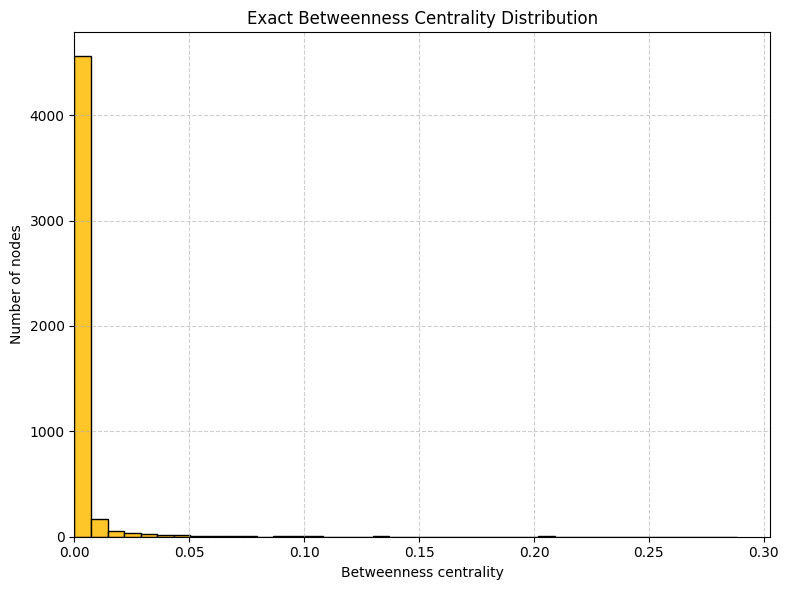

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_betweenness_distribution(G, bins=40):
    betweenness = nx.betweenness_centrality(G, normalized=True)

    values = np.array(list(betweenness.values()))
    print(max(values))

    plt.figure(figsize=(8, 6))
    plt.hist(values, bins=bins, edgecolor="black", color='#ffc62a')
    plt.xlabel("Betweenness centrality")
    plt.ylabel("Number of nodes")
    plt.title("Exact Betweenness Centrality Distribution")
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(left=0)
    plt.show()

plot_betweenness_distribution(G)